# Cats Vs. Dogs
### Eden Trainor


#### Imports


In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn as skl

from random import randint
from copy import deepcopy

#making things pretty
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 #Image resizing
import os
from tqdm import tqdm

from sklearn.utils import shuffle as mutual_shuffle
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator


#Set test colurs to white for dark theme notebook
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

#### Load Data

Global Variable setting:


In [2]:
USER_NAME = 'EdenTrainor' #Configure this with your username
DATA_REPO = 'C:/Users/{}/Datalytyx/Delivery - Documents/Data Science/Data/'.format(USER_NAME)

#Path of actual image JPGs
TRAIN_IMAGES_FOLDER = '{}Cat_VS_Dog/all/train_images/'.format(DATA_REPO)
TEST_IMAGES_FOLDER = '{}Cat_VS_Dog/all/test_images/'.format(DATA_REPO)

#Path of images as resized arrays
TRAIN_ARRAYS_FOLDER = '{}Cat_VS_Dog/all/train_arrays/'.format(DATA_REPO)
TEST_ARRAYS_FOLDER = '{}Cat_VS_Dog/all/test_arrays/'.format(DATA_REPO)


#Images will be resized to a square of size:
IMAGE_SIZE = 64
EVAL_SPLIT_SIZE = 5000




Create function to parse images into list of arrays and extract labels from image names

In [3]:
#Function to parse labels from image files

def label_parser(img_path):
    #get label from image name: e.g. dog.93.jpg
    word_label = img_path.split('.')[0]
    
    
    #One Hot the labels
    if word_label == 'dog': 
        return [1, 0]
    
    elif word_label == 'cat': 
        return [0, 1]
    
    # Deal with exceptions but don't stop process.
    else: 
        print('Unable to parse label for {}'.format(img_path))

        
        
def create_train_data():
    train_images = []
    train_labels = []
    
    for img in tqdm(os.listdir(TRAIN_IMAGES_FOLDER)):
        
        #Label the image
        label = label_parser(img)
        
        
        path = os.path.join(TRAIN_IMAGES_FOLDER, img)
        
        img = cv2.imread(path)
        
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        
        train_images.append(img)
        train_labels.append(label)
    
    #Stack images
    train_images = np.stack(train_images, axis = 0)
    train_labels = np.stack(train_labels, axis = 0)    
   
    np.save('{}train_images-{}.npy'.format(TRAIN_ARRAYS_FOLDER, IMAGE_SIZE), train_images)
    np.save('{}train_labels-{}.npy'.format(TRAIN_ARRAYS_FOLDER, IMAGE_SIZE), train_labels)
    
    return train_images, train_labels
        
    

For first time runs, or for changing image sizes, run the below cell:

In [4]:
#train_images, train_labels = create_train_data()

For reloading the kernel we'll just load up the arrays we saved

In [5]:
train_images = np.load('{}train_images-{}.npy'.format(TRAIN_ARRAYS_FOLDER, IMAGE_SIZE))
train_labels = np.load('{}train_labels-{}.npy'.format(TRAIN_ARRAYS_FOLDER, IMAGE_SIZE))

Do the same for test data. But just export to array.

In [6]:
def process_test_data():
    test_data = []
    
    for img in tqdm(os.listdir(TEST_IMAGES_FOLDER)):
        
        path = os.path.join(TEST_IMAGES_FOLDER, img)
        
        img_num = img.split('.')[0]
        
        img = cv2.imread(path)
        
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        
        test_data.append([img, img_num])
    
    test_data = np.stack(test_data, axis = 0)
        
    np.save('{}test_images-{}.npy'.format(TEST_ARRAYS_FOLDER, IMAGE_SIZE), test_data)

In [7]:
#process_test_data()

Split data into train/eval features/labels and shuffle the data.

In [8]:
train_X, eval_X, train_y, eval_y = train_test_split(train_images, train_labels,
                                                    random_state = 0,
                                                    test_size = 0.2)

## Experimental Data Analysis

Lets look at some of our images:

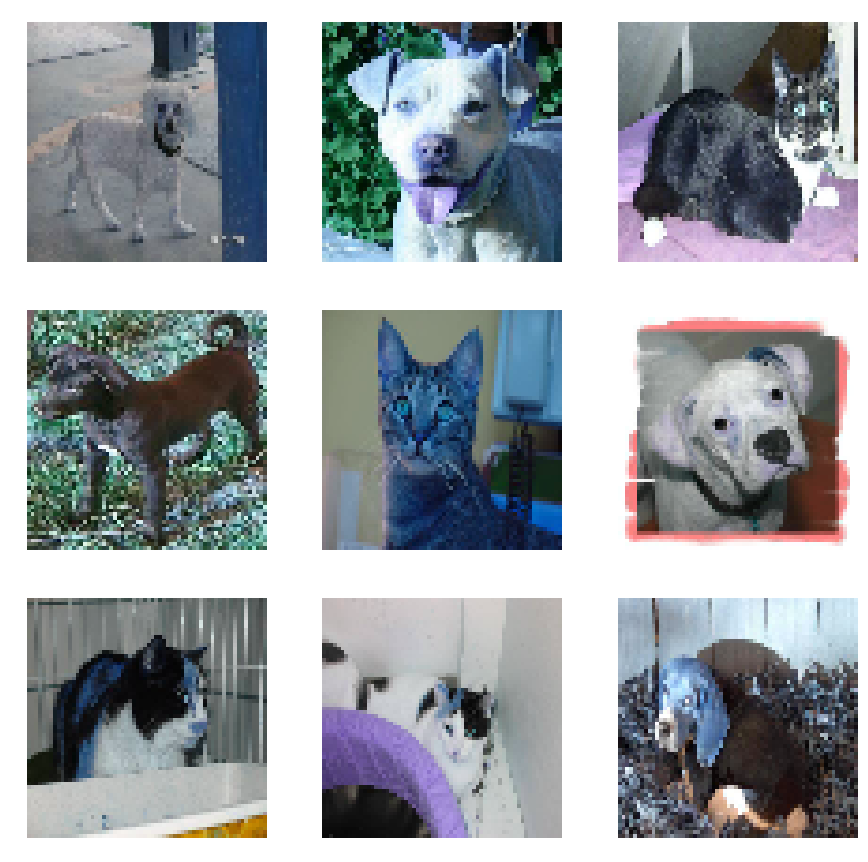

In [296]:
#Plot a few of the images
fig, ax = plt.subplots(3, 3,
                      sharex='col', 
                      sharey='row', 
                      figsize=(15, 15))

label_set = np.array(['cat', 'dog'])

for i in range(3):
    for j in range(3):
        
        #pick random image
        
        img_index = randint(0, train_y.shape[0])
        ax[i, j].imshow(train_X[img_index])

        ax[i, j].set_title('{} - index: {}'.format(label_set[train_y[img_index][0]], img_index), color = 'w')
        
        ax[i, j].axis('off')
        

Look at the distribution of target classes in dataset

In [83]:
print('Number of dogs in training set {}, number of cats in training set {}'.format(train_y[:,0].sum(), train_y[:,1].sum()))

Number of dogs in training set 9996, number of cats in training set 10004


In [84]:
print('Number of dogs in evaluation set {}, number of cats in evaluation set {}'.format(eval_y[:,0].sum(), eval_y[:,1].sum()))

Number of dogs in evaluation set 2504, number of cats in evaluation set 2496


Text(0.5,1,'Number of cat/dogs in each dataset')

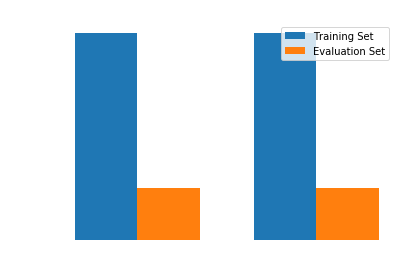

In [85]:
fig, ax = plt.subplots(1, 1)

x_position = np.arange(2)
bar_width = 0.35

ax.bar(x = x_position,
       height = (train_y[:,0].sum(), train_y[:,1].sum()),
       width = bar_width,
       label = 'Training Set'
      )

ax.bar(x = x_position + bar_width,
       height = (eval_y[:,0].sum(), eval_y[:,1].sum()),
       width = bar_width,
       label = 'Evaluation Set'
      )

ax.set_xlabel('Set')
ax.set_ylabel('Count')
ax.set_xticks(x_position + bar_width / 2)
ax.set_xticklabels(('Cats', 'Dogs'))
ax.legend()
ax.set_title('Number of cat/dogs in each dataset', color = 'w')

Obvious that the datset is stratified properly and there is no large imbalance in class sizes.

#### Edge Detection Filters

In [86]:
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage import feature

Look at image through 4 edge detection filters, filters work on grayscale images.

In [315]:

test_image = train_X[randint(0, 20000)]
grey_test_image = cv2.cvtColor(train_X[0:4], cv2.COLOR_RGB2GRAY)
grey_test_image.shape

error: OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\modules\imgproc\src\color.cpp:11147: error: (-215) scn == 3 || scn == 4 in function cv::cvtColor


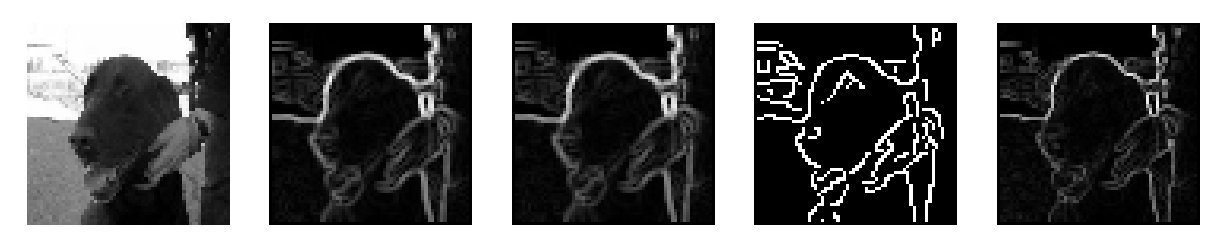

In [286]:
def edge_filter_plots(test_img):    
    
    edge_canny = feature.canny(test_img)
    edge_roberts = roberts(test_img)
    edge_sobel = sobel(test_img)
    edge_prewitt = prewitt(test_img)

    fig, ax = plt.subplots(ncols=5, sharex=True, sharey=True, figsize=(21, 10.5))

    ax[0].imshow(test_img, cmap=plt.cm.gray)
    ax[0].set_title('Test Image', color = 'w')

    ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
    ax[1].set_title('Sobel Edge Detection', color = 'w')

    ax[2].imshow(edge_prewitt, cmap=plt.cm.gray)
    ax[2].set_title('Prewitt Filter', color = 'w')

    ax[3].imshow(edge_canny, cmap=plt.cm.gray)
    ax[3].set_title('Canny Filter', color = 'w')

    ax[4].imshow(edge_roberts, cmap=plt.cm.gray)
    ax[4].set_title('Roberts Edge Detection', color = 'w')

    for a in ax:
        a.axis('off')
        
        
edge_filter_plots(cv2.cvtColor(train_X[randint(0, 20000)], cv2.COLOR_RGB2GRAY))

### Colour Distrbutions

Look at colour distributions between classes. Hoping that the background will cancel. Basically, lets see if it's worth greyscaling the imagees considering there's not mutch difference between cats and dogs color wise. 

If we make the assumption that most of the animals are in the centre of the image, we can further isolate the pixels corresponding to the animals themselves by weighting the pixels on a guassian bell curve from the centre.

#### Without bell-curve weighting

Calculate the red, green and blue mean values, per image, for each cats and dogs.

In [71]:

red_means, blue_means, green_means = [], [], []

#Split images into classes
cat_mask = np.where(train_labels[:, 0] == 0)
dog_mask = np.where(train_labels[:, 0] == 1)

cat_images = train_images[cat_mask[0]]
dog_images = train_images[dog_mask[0]]


#Calculate means of each channel of images
cat_means = np.mean(cat_images, axis = (1, 2))
dog_means = np.mean(dog_images, axis = (1, 2))



Text(0.5,1,'Dogs colour distribution')

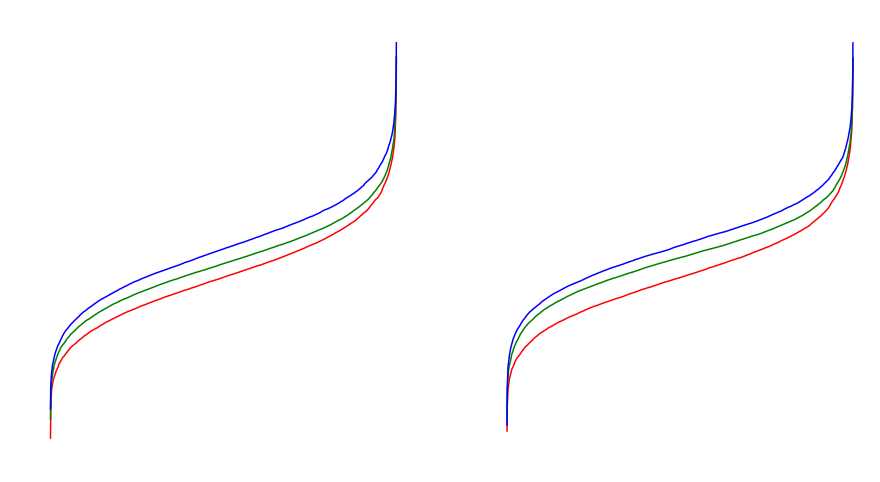

In [77]:
#Plot the means 
fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (15, 8))

xs = np.arange(12500)

#Cats plot
ax[0].plot(xs, np.sort(cat_means[:, 0]), color = 'red')
ax[0].plot(xs, np.sort(cat_means[:, 1]), color = 'green')
ax[0].plot(xs, np.sort(cat_means[:, 2]), color = 'blue')

# ax[0].fill_between(xs, np.sort(cat_means[:, 0]), where = ys >= np.sort(cat_means[:, 0]), interpolate = True, color = 'red', alpha = 0.5)
# ax[0].fill_between(xs, np.sort(cat_means[:, 1]), where = ys <= np.sort(cat_means[:, 1]), interpolate = True, color = 'green', alpha = 0.5)
# ax[0].fill_between(xs, np.sort(cat_means[:, 2]), where = ys <= np.sort(cat_means[:, 2]), interpolate = True, color = 'blue', alpha = 0.5)

ax[0].set_title('Cats colour distribution', color = 'w')

#Dogs plot
ax[1].plot(xs, np.sort(dog_means[:, 0]), color = 'red')
ax[1].plot(xs, np.sort(dog_means[:, 1]), color = 'green')
ax[1].plot(xs, np.sort(dog_means[:, 2]), color = 'blue')

# ax[1].fill_between(xs, np.sort(dog_means[:, 0]), where = ys >= np.sort(dog_means[:, 0]), interpolate = True, color = 'red', alpha = 0.5)
# ax[1].fill_between(xs, np.sort(dog_means[:, 1]), where = ys <= np.sort(dog_means[:, 1]), interpolate = True, color = 'green', alpha = 0.5)
# ax[1].fill_between(xs, np.sort(dog_means[:, 2]), where = ys <= np.sort(dog_means[:, 2]), interpolate = True, color = 'blue', alpha = 0.5)

ax[1].set_title('Dogs colour distribution', color = 'w')

Although there does seem to be a difference, it's not very obvious plotted in this way: maybe look at cumulative summation instead:

Text(0.5,1,'Dogs colour distribution')

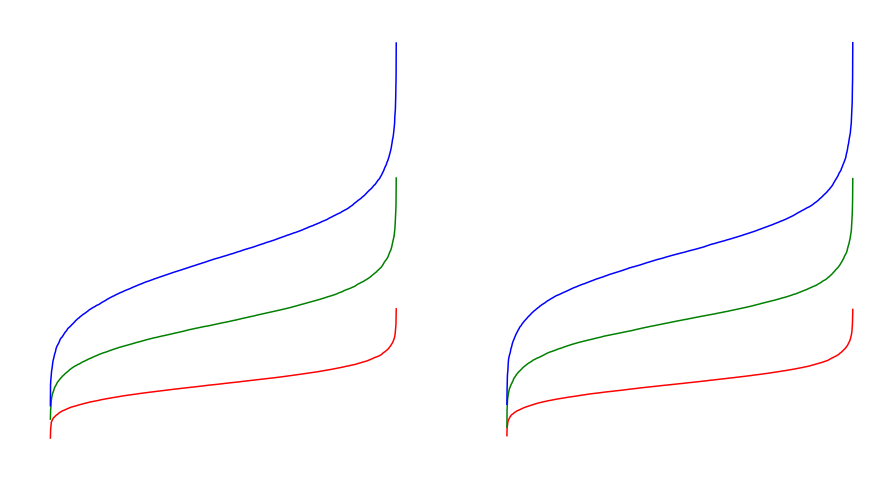

In [76]:
#Cumulative means
cat_means_cml = cat_means.cumsum(axis = 1)
dog_means_cml = dog_means.cumsum(axis = 1)

#Plot the means 
fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (15, 8))

xs = np.arange(12500)

#Cats plot
ax[0].plot(xs, np.sort(cat_means_cml[:, 0]), color = 'red')
ax[0].plot(xs, np.sort(cat_means_cml[:, 1]), color = 'green')
ax[0].plot(xs, np.sort(cat_means_cml[:, 2]), color = 'blue')

ax[0].set_title('Cats colour distribution', color = 'w')

#Dogs plot
ax[1].plot(xs, np.sort(dog_means_cml[:, 0]), color = 'red')
ax[1].plot(xs, np.sort(dog_means_cml[:, 1]), color = 'green')
ax[1].plot(xs, np.sort(dog_means_cml[:, 2]), color = 'blue')

ax[1].set_title('Dogs colour distribution', color = 'w')

Still not very obvious, lets look compare the colours individually:

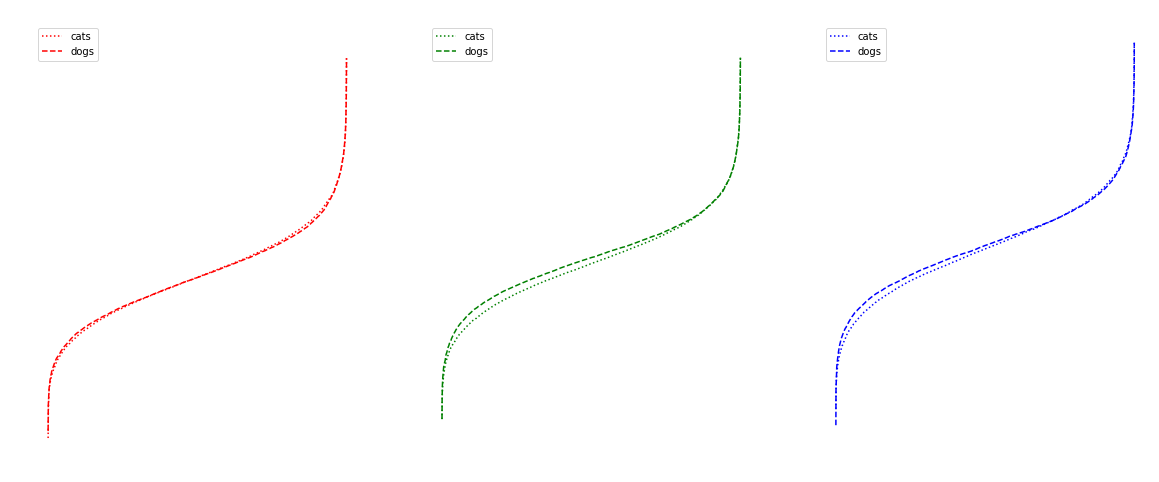

In [104]:
#Plot the means 
fig, ax = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (20, 8))

xs = np.arange(12500)

ax[0].plot(xs, np.sort(cat_means[:, 0]), color = 'red', label = 'cats', linestyle = ':')
ax[0].plot(xs, np.sort(dog_means[:, 0]), color = 'red', label = 'dogs', linestyle = '--')
ax[0].set_title('Red colour distribution', color = 'w')
ax[0].legend()

ax[1].plot(xs, np.sort(cat_means[:, 1]), color = 'green', label = 'cats', linestyle = ':')
ax[1].plot(xs, np.sort(dog_means[:, 1]), color = 'green', label = 'dogs', linestyle = '--')
ax[1].set_title('Green colour distribution', color = 'w')
ax[1].legend()

ax[2].plot(xs, np.sort(cat_means[:, 2]), color = 'blue', label = 'cats', linestyle = ':')
ax[2].plot(xs, np.sort(dog_means[:, 2]), color = 'blue', label = 'dogs', linestyle = '--')
ax[2].set_title('Blue colour distribution', color = 'w')
ax[2].legend()

#### With Gaussian Bell curve fitting

So far there doesn't seem to be a massive difference in the images. Although it does seem that dog images have higher levels of green and blue on average.

Lets try fitting the gaussian bell curve to the data inthe hopes of isolating more of the pixels pertaining to the animals:

In [106]:
from scipy.ndimage.filters import gaussian_filter

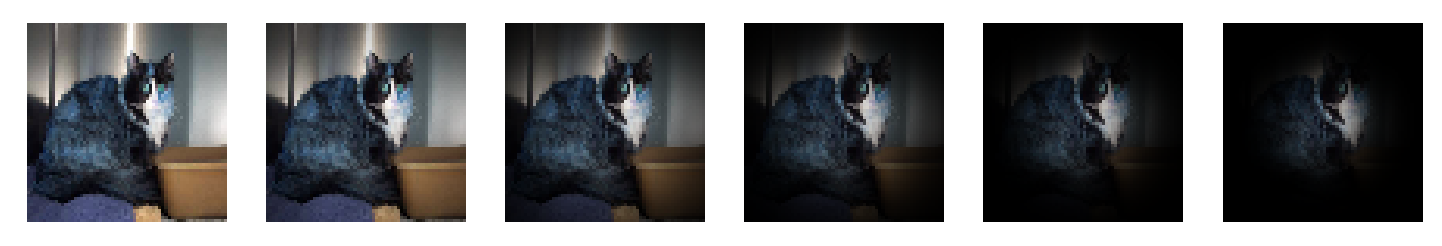

In [229]:
import scipy.stats as st

def gaussian_kern(kern_len=64, n_sig=3):
    """Returns a 2D Gaussian kernel array."""
    
    #Create kernel
    interval = (2 * n_sig + 1) / (kern_len)
    
    #Define Kernel Space
    x = np.linspace(- n_sig - interval / 2, n_sig + interval / 2, kern_len + 1)
    
    #Make 1D bellcurve
    kern1d = np.diff(st.norm.cdf(x))
    
    #Make 2D bellcurve
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    
    #normalize kernal between 0, 1    
    kernel = kernel_raw / kernel_raw.sum()
    
    kernel_max =  kernel.flatten()[kernel.argmax()]    
    kernel = kernel / kernel_max
    
    return kernel

test_image = train_X[randint(0, 20000)]

#Examples off kernel effects
NUM_SIGMAS = 6

fig, ax = plt.subplots(1, NUM_SIGMAS, figsize = (25, 15))

for num in range(NUM_SIGMAS):
    ax[num].imshow((test_image*gaussian_kern(kern_len=64, n_sig=num)[:,:, None]).astype(int))
    ax[num].set_title('Image with applied kernal, sigma = {}'.format(num), color = 'w')
    ax[num].axis('off')

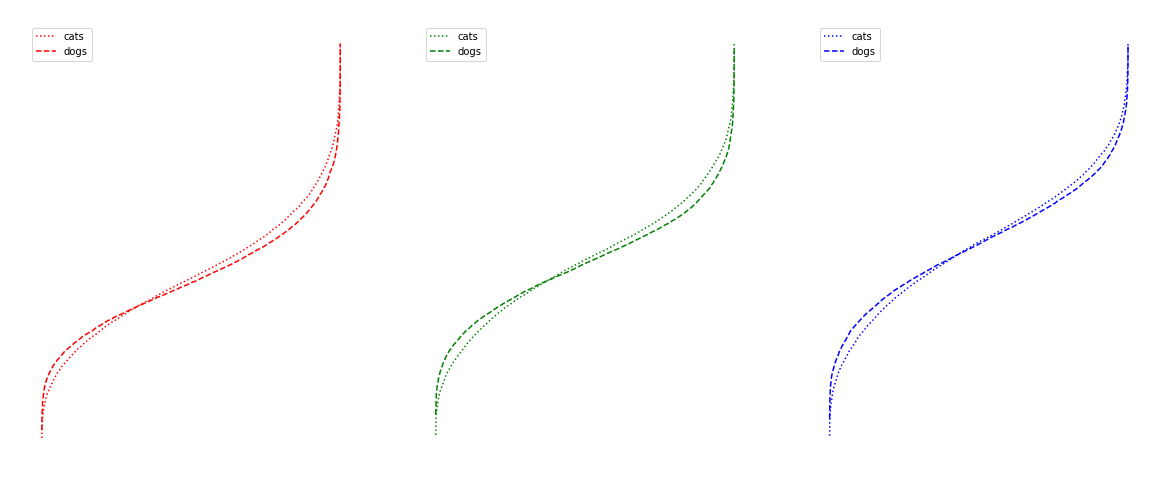

In [215]:
gaus_dog_images = dog_images*gaussian_kern(kern_len = 64, n_sig = 5)[None, :,:, None]
gaus_cat_images = cat_images*gaussian_kern(kern_len = 64, n_sig = 5)[None, :,:, None]


#Calculate means of each channel of images
gaus_cat_means = np.mean(gaus_cat_images, axis = (1, 2))
gaus_dog_means = np.mean(gaus_dog_images, axis = (1, 2))
#Plot the means 
fig, ax = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (20, 8))

xs = np.arange(12500)

ax[0].plot(xs, np.sort(gaus_cat_means[:, 0]), color = 'red', label = 'cats', linestyle = ':')
ax[0].plot(xs, np.sort(gaus_dog_means[:, 0]), color = 'red', label = 'dogs', linestyle = '--')
ax[0].set_title('Red colour distribution', color = 'w')
ax[0].legend()

ax[1].plot(xs, np.sort(gaus_cat_means[:, 1]), color = 'green', label = 'cats', linestyle = ':')
ax[1].plot(xs, np.sort(gaus_dog_means[:, 1]), color = 'green', label = 'dogs', linestyle = '--')
ax[1].set_title('Green colour distribution', color = 'w')
ax[1].legend()

ax[2].plot(xs, np.sort(gaus_cat_means[:, 2]), color = 'blue', label = 'cats', linestyle = ':')
ax[2].plot(xs, np.sort(gaus_dog_means[:, 2]), color = 'blue', label = 'dogs', linestyle = '--')
ax[2].set_title('Blue colour distribution', color = 'w')
ax[2].legend()

From these plots we can see that there is a clear difference in colours between centers fo the cats and the dogs images.

Although we will benchmark largly on grayscale images it seems it would be worth inserting all channels into the model to take account for colour information.

## Preprocessing

#### PCA
Look into using PCA to compress images before normalizign them and ingesting them.

NOTE: it's likely we'll want ot put the PCA and Normalization in the pipeline

In [366]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


Single image: problem is it's only reducing it by one axis - tod do with how PCA considers columns and features.
ALSO MEANS THAT EACH IMAGE IS GETTING SEPERATE COMPONENT ANALYSIS -- Different compression patterns per image

In [401]:
grey_test_image = cv2.cvtColor(train_X[randint(0, 20000)], cv2.COLOR_RGB2GRAY)

pca = PCA(n_components = 25)


X_reduced = pca.fit_transform(grey_test_image)
#X_recovered = pca.inverse_transform(X_reduced)

cumsum = np.cumsum(pca.explained_variance_ratio_)

d = np.argmax(cumsum >= 0.95) + 1

print('Compressed number of componants explaining 95% of the variance: {}\nGiving a compression rate of: {}%'.format(d, d/np.prod(grey_test_image.shape)*100))

#Recover compressed image to original size
X_recovered = pca.inverse_transform(X_reduced)


#Compare compressed and uncompressed images for comparison
fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (18, 9))

ax[0].imshow(grey_test_image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(X_recovered, cmap=plt.cm.gray)
ax[1].set_title('Recovered')



for axes in ax:
    axes.axis('off')

ValueError: Expected 2D array, got 1D array instead:
array=[240. 242. 246. ... 147. 218. 216.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [410]:
pca_data = aug_data_.reshape((-1, 64**2))

pca = PCA(n_components = 25)


X_reduced = pca.fit_transform(pca_data)
#X_recovered = pca.inverse_transform(X_reduced)

cumsum = np.cumsum(pca.explained_variance_ratio_)

d = np.argmax(cumsum >= 0.95) + 1

print('Compressed number of componants explaining 95% of the variance: {}\nGiving a compression rate of: {}%'.format(d, d/np.prod(grey_test_image.shape)*100))

#Recover compressed image to original size
X_recovered = pca.inverse_transform(X_reduced)

img_index
#Compare compressed and uncompressed images for comparison
fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (18, 9))

ax[0].imshow(pca_data, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(X_recovered, cmap=plt.cm.gray)
ax[1].set_title('Recovered')



for axes in ax:
    axes.axis('off')

(25000, 4096)

LOOK INTO PERFORMING PCA OVER WHOLE DATASET AND FINDING OUT HOW MANY COMPONENTS ON AVERAGE ARE NEEDED TO EXPLAIN 95% OF THE VARIANCE IN THE WHOLE DATASET AND COMPRESS IMAGES TO A SQUARE NUMBER JUST ABOVE THAT
SQUARE NUMBERS:

In [388]:
print([i**2 for i in range(19)])

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324]


#### Normalization
Look at image normalization

NOTE: For leaky_relu activation we want to scale between 0, 1.

In [91]:
#Use a transformer for this bit for the sake of reusability
class ImageNormalizer(TransformerMixin, BaseEstimator):
    """
    A normalizer for RGB/Greyscale images, either batch or stream.
    images must be in numpy arrays of the shape (batch_size, img_shape[1], img_shape[2], channels)
    """
    
    def __init__(self, mode = 'batch'):
        """
        Mode can dictate normalization per: 'image', 'channel', or 'batch'
        """
        
        self.mode = mode
        
    def fit(self, X, y = None):
        """
        Description
        -----------
        No fitting on dataset, images are normalized per image.
        
        Authors
        -------
        Eden Trainor
        """
        return self
    
    def transform(self, X):
        """
        Description
        -----------
        Calculate means/std for each channel of each image and normalize using these values.
        
        Args
        ----
        X: np.ndarray, (batch_size, img_shape[1], img_shape[2], channels)
            Array of numpy arrays with same image shapes and number of channels each.
            
        Returns
        -------
        norm_X: np.ndarray, (batch_size, img_shape[1], img_shape[2], channels)
            Array of normalized images.
        """
        
        assert isinstance(X, np.ndarray)
        
        if self.mode == 'channel':
            #Calculate mean per image, per channel
            mus = np.mean(X, axis = (1, 2))

            #Calculate standard deviation per image, per channel
            sigmas = np.std(X, axis = (1, 2))

            #Take away 
            norm_X = (X -  mus[ :, None, None, :]) / sigmas[ :, None, None, :]

            return norm_X
        
        
        elif self.mode == 'batch':

            #Calculate mean per image, per batch
            mus = np.mean(X, axis = (1, 2, 3))

            #Calculate standard deviation per image, per batch
            sigmas = np.std(X, axis = (1, 2, 3))

            #Take away 
            norm_X = (X -  mus[ :, None, None, None]) / sigmas[ :, None, None, None]

            return norm_X
        
        
        elif self.mode == 'image':
            
            #Calculate mean per image, per image
            mus = np.mean(X, axis = (1, 2))

            #Calculate standard deviation per image, per batch
            sigmas = np.std(X, axis = (1, 2))

            #Take away 
            norm_X = (X -  mus[ :, None, None, :]) / sigmas[ :, None, None, :]

            return norm_X
    
    def fit_transform(self, X, y = None):
        """
        Combines the fit and transform methods of this class
        """
        return self.fit(X, y).transform(X)
        
        

In [92]:
to_norm = train_X[0:4]

mus = np.mean(to_norm, axis = (1, 2, 3))

sigmas = np.std(to_norm, axis = (1, 2, 3))

In [93]:
normed = (to_norm -  mus[ :, None, None, None]) / sigmas[ :, None, None, None]

In [94]:
normed[0].std()

1.0

In [96]:
normalized_images = ImageNormalizer().fit_transform(train_X[0:3])

In [97]:
normed[0, :, :, 1]

array([[ 1.36867601,  1.55144489,  1.49052193, ..., -0.8448582 ,
        -0.31685922, -0.82455055],
       [ 1.40929131,  1.51082958,  1.44990662, ..., -1.04793473,
        -0.60116636, -0.70270463],
       [ 1.51082958,  1.53113723,  1.49052193, ..., -1.29162657,
        -1.10885769, -0.78393524],
       ...,
       [ 0.1096015 ,  0.29237038,  0.23144742, ...,  0.96252294,
         0.98283059,  0.96252294],
       [ 0.35329334,  0.35329334,  0.25175508, ...,  0.94221529,
         0.96252294,  0.96252294],
       [ 0.23144742,  0.23144742,  0.29237038, ...,  0.98283059,
         1.04375355,  0.94221529]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


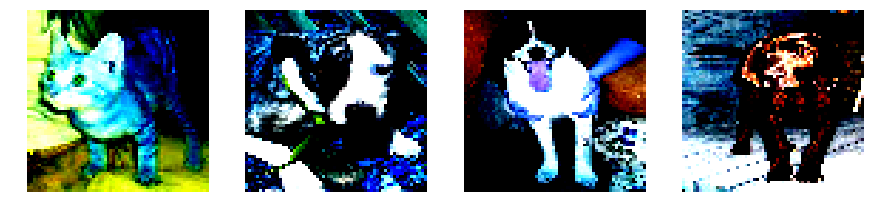

In [217]:
fig, ax = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (15, 7))

for indx, image in enumerate(normed):
    ax[indx].imshow(image.astype(float), cmap = 'brg')
    ax[indx].axis('off')

## Data Augmentation techniques

NOTE: You will only want to apply these techniques to the traind data and not the test or evaluation data!!

In [ ]:
from scipy import rotate
from scipy.ndimage.interpolation 

#### Horizontal flipping
Pretty simple technique, doubles the size fo your training data.

Define a flip function to perform this for automation:

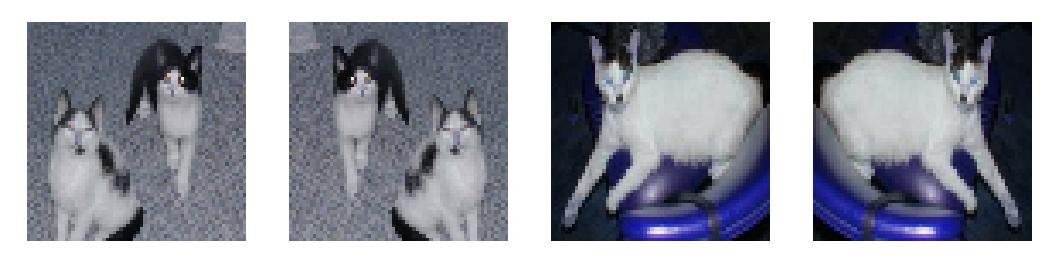

In [317]:
def image_flip(image_array, axis = 'horizontal'):
    """
    Description
    -----------
    Flips images either horizontally or vertically.
    
    Args
    ----
    image_array: np.ndarray, (batch_size, img_ax_1, img_ax_2, channels)
        Array of images to be flipped.
        
    Returns
    -------
    flipped image array of same shape and size.
    """
    
    arr_shape = image_array.shape
    
    #Batch/coloured
    if len(arr_shape) == 4:
        if axis == 'horizontal':
            return image_array[:, :, ::-1, :]
        if axis == 'vertical':
            return image_array[:, ::-1, :, :]
        
    #Batch/grayscale
    elif len(arr_shape) == 3 and arr_shape[-1] > 3:
        if axis == 'horizontal':
            return image_array[:, :, ::-1]
        if axis == 'vertical':
            return image_array[:, ::-1, :]
        
    #Single Image/coloured
    elif len(arr_shape) == 3 and arr_shape[-1] <= 3:
        if axis == 'horizontal':
            return image_array[:, ::-1, :]
        if axis == 'vertical':
            return image_array[::-1, :, :]
        
    #Single Image/greyscale
    elif len(arr_shape) == 2:
        if axis == 'horizontal':
            return image_array[:, ::-1]
        if axis == 'vertical':
            return image_array[::-1, :]        
    
    
flipped_images = image_flip(train_X)

fig, ax = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (18, 9))

for indx in range(0, 3, 2):
    
    img_indx = randint(0, 20000)
    
    ax[indx].imshow(train_X[img_indx])
    ax[indx].set_title('Original', color = 'w')


    ax[indx + 1].imshow(flipped_images[img_indx]) #Flipping as simple as reversing indecies fo a single axis
    ax[indx + 1].set_title('Flipped', color = 'w')
    
    ax[indx].axis('off')
    ax[indx + 1].axis('off')
    

#### Rotating Image

Convolutional Kernals are rotationally invarient so even small rotations are seen as completely new to the network.

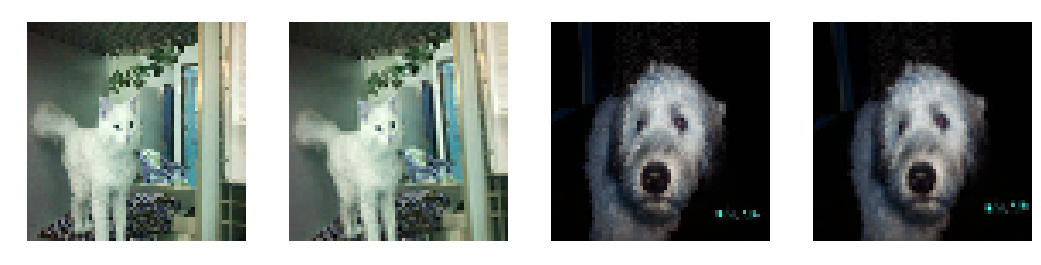

In [306]:
from scipy.ndimage.interpolation import rotate 

def image_rotate(image_array, angle = 5):
    """
    Description
    -----------
    Rotates an image by a set number of degrees.
    
    Args
    ----
    image_array: np.ndarray, (batch_size, img_ax_1, img_ax_2, channels)
        Array of images to be rotated.
        
    Returns
    -------
    Rotated image array of same shape and size.
    """
    
    return rotate(input = image_array, axes = (1, 2), angle = 5, mode = 'constant')


rotated_images = rotate(train_X[:20], axes = (1, 2), reshape = False, mode = 'nearest', angle = 5)

fig, ax = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (18, 9))

for indx in range(0, 3, 2):
    
    img_indx = randint(0, 20)
    
    ax[indx].imshow(train_X[img_indx])
    ax[indx].set_title('Original', color = 'w')


    ax[indx + 1].imshow(rotated_images[img_indx]) #Flipping as simple as reversing indecies fo a single axis
    ax[indx + 1].set_title('Rotated', color = 'w')
    
    ax[indx].axis('off')
    ax[indx + 1].axis('off')
    

#### Translating Image

Translating the image also makes it a completely different image to the neural network.

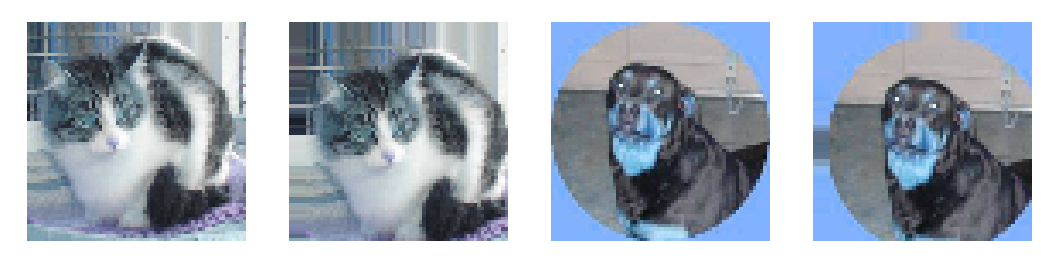

In [313]:
from scipy.ndimage.interpolation import rotate, shift

shifted_images = shift(train_X[:20], (0, 4, 4, 0), mode = 'nearest')

fig, ax = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (18, 9))

for indx in range(0, 3, 2):
    
    img_indx = randint(0, 20)
    
    ax[indx].imshow(train_X[img_indx])
    ax[indx].set_title('Original', color = 'w')


    ax[indx + 1].imshow(shifted_images[img_indx]) #Flipping as simple as reversing indecies fo a single axis
    ax[indx + 1].set_title('Shifted', color = 'w')
    
    ax[indx].axis('off')
    ax[indx + 1].axis('off')
    

## Image Set Generation

Generate and parse data in greyscale

In [261]:
AUGMENTED_FOLDER = '{}augmented_arrays/'.format(TRAIN_ARRAYS_FOLDER)

In [316]:
def gray_create_train_data():
    train_images = []
    train_labels = []
    
    for img in tqdm(os.listdir(TRAIN_IMAGES_FOLDER)):
        
        #Label the image
        label = label_parser(img)
        
        
        path = os.path.join(TRAIN_IMAGES_FOLDER, img)
        
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        
        train_images.append(img)
        train_labels.append(label)
    
    #Stack images
    train_images = np.stack(train_images, axis = 0)
    train_labels = np.stack(train_labels, axis = 0)    
   
    np.save('{}train_images-{}-gray.npy'.format(TRAIN_ARRAYS_FOLDER, IMAGE_SIZE), train_images)
    np.save('{}train_labels-{}-gray.npy'.format(TRAIN_ARRAYS_FOLDER, IMAGE_SIZE), train_labels)
    
    return train_images, train_labels

In [318]:
# Greyscale the data
aug_data_, aug_labels_ = gray_create_train_data()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:51<00:00, 487.29it/s]


In [325]:
for i, j, k in ([0, 0, 0], [0, 0, 1], [4, 5, 6]):
    print( i, j, k)

0 1 2
2 3 4
4 5 6


In [361]:
from itertools import permutations, combinations
list(combinations([0, 1, 1], 3))

[(0, 1, 1)]

In [355]:
perm_list = sorted([(0, 1, 1), (1, 1, 0), (1, 0, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, 0), (1, 1, 1)])

In [406]:
#List of techniques for file nameing
aug_techniques = np.array(['flipped', 'rotated', 'shifted'])


#Each layer of augmentation doubles the number of examples
# for flipped in [0, 1]:
#     for rotated in [0, 1]:
#         for shifted in [0, 1]:

for flipped, rotated, shifted in tqdm(perm_list):
    
           
    aug_data = aug_data_
    aug_labels = aug_labels_

    #Perform Augmentations
    if flipped:

        flipped_data = image_flip(aug_data)

        aug_data = np.concatenate([aug_data, flipped_data], axis = 0)
        aug_labels = np.concatenate([aug_labels, aug_labels], axis = 0)
#         print(aug_data.shape)
        
    if rotated:

        rotated_data = rotate(aug_data, axes = (1, 2), reshape = False, mode = 'nearest', angle = 5)

        aug_data = np.concatenate([aug_data, rotated_data], axis = 0)
        aug_labels = np.concatenate([aug_labels, aug_labels], axis = 0)
#         print(aug_data.shape)
        
    if shifted:

        shifted_data = shift(aug_data, (0, 4, 4), mode = 'nearest')

        aug_data = np.concatenate([aug_data, shifted_data], axis = 0)
        aug_labels = np.concatenate([aug_labels, aug_labels], axis = 0)
#         print(aug_data.shape)

    #Name and save files
    if not (flipped or rotated or shifted):
                
        file_name = 'none'
                
    else:
                
        file_name_mask = np.asarray([flipped, rotated, shifted]).astype(bool)

        file_name = '-'.join(aug_techniques[file_name_mask])
            
#     print('SAVED: train-{}'.format(file_name))              

#     np.save(('{}train-data-{}.npy'.format(AUGMENTED_FOLDER, file_name)), aug_data)
#     np.save(('{}train-labels-{}.npy'.format(AUGMENTED_FOLDER, file_name)), aug_labels)





  0%|                                                                                            | 0/8 [00:00<?, ?it/s]



 25%|█████████████████████                                                               | 2/8 [00:34<01:43, 17.29s/it]



 38%|███████████████████████████████▌                                                    | 3/8 [00:45<01:17, 15.50s/it]

KeyboardInterrupt: 